In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_subject_levels

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')

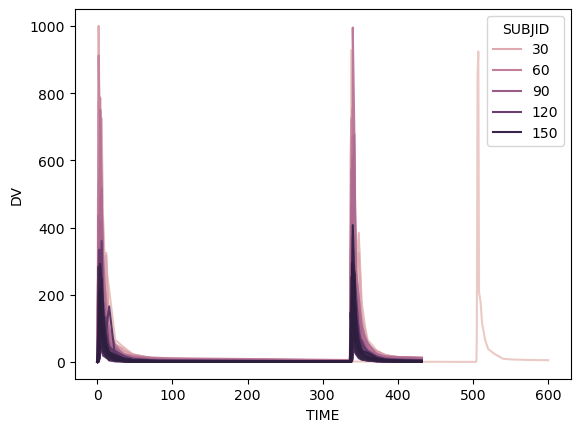

In [3]:
plot_subject_levels(df)

In [4]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function

In [5]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

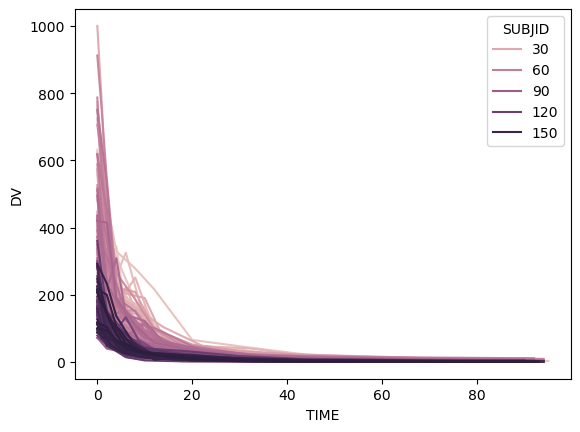

In [6]:
#plot the prepared data
plot_subject_levels(work_df)

In [7]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib

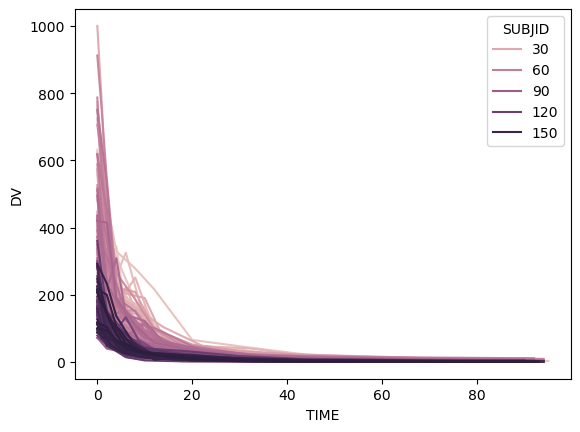

In [8]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
mgkg_scaler = RobustScaler()
age_scaler = RobustScaler()
wt_scaler = RobustScaler()

scale_df['MGKG'] = (scale_df['DOSR'] / scale_df['WT'])
scale_df['WT_scale'] = wt_scaler.fit_transform(scale_df[['WT']])
scale_df['MGKG_scale'] = mgkg_scaler.fit_transform(scale_df[['MGKG']])
scale_df['AGE_scale'] = age_scaler.fit_transform(scale_df[['AGE']])
scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

In [9]:
scale_df

,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,MGKG,WT_scale,MGKG_scale,AGE_scale
2,1.0,1.0,1.0,0.0,1.0,3.0,NaN,275.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
3,1.0,1.0,1.0,1.0,2.0,3.0,NaN,244.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
4,1.0,1.0,1.0,2.0,3.0,3.0,NaN,151.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
5,1.0,1.0,1.0,3.0,4.0,3.0,NaN,130.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
6,1.0,1.0,1.0,5.0,6.0,3.0,NaN,147.0,0.0,B,1.0,26.0,84.0,3.571429,0.3125,0.248950,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,159.0,1.0,1.0,21.0,24.0,1.0,NaN,7.91,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
11,159.0,1.0,1.0,33.0,36.0,1.0,NaN,3.02,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
12,159.0,1.0,1.0,45.0,48.0,1.0,NaN,1.7,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429
13,159.0,1.0,1.0,69.0,72.0,1.0,NaN,1.42,1.0,B,1.0,33.0,95.0,1.052632,1.0000,-0.745975,0.571429


# Just Optimizing the ODE

In [10]:
from scipy.optimize import minimize

run_ode_only = False
if run_ode_only:
# opt_df = opt_df.loc[opt_df['TIME'] >= 1, :].copy()
    initial_guess = [0.6, 2.0]  # Initial guesses for k and Vd
    result_0 = optimize_with_checkpoint_joblib(objective_function, initial_guess, n_checkpoint=5, checkpoint_filename='check.jb', args=(
        # Bounds added to prevent negative values
        scale_df,), bounds=[(1e-6, None), (1e-6, None)])
    # result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

result_0


# With Covariates

In [11]:
from utils import ObjectiveFunctionColumn

In [12]:
from utils import arbitrary_objective_function
import warnings
import joblib as jb

run_test_mod = False
if run_test_mod:
    warnings.filterwarnings("error", category= RuntimeWarning)

    initial_guess = [np.log(0.6), np.log(2.0), 0, 0, 0 ] 
    objective_func_arbit_allometric = partial(arbitrary_objective_function,
                                dep_vars = {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                    ObjectiveFunctionColumn('SEX')],
                                            'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                            model_method='allometric', 
                                                                            allometric_norm_value=wt_scaler.transform([[70]])[0][0]
                                                                            )]})
    result_arbit_allo = optimize_with_checkpoint_joblib(objective_func_arbit_allometric, initial_guess, n_checkpoint=5, checkpoint_filename='check_args_arbit_al.jb', args=(
        # Bounds added to prevent negative values
        scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None),])

    with open('result_arbit_allo.jb', 'wb') as f:
        jb.dump(result_arbit_allo, f)
else:
    with open('result_arbit_allo.jb', 'rb') as f:
        result_arbit_allo = jb.load(f)

In [13]:
result_arbit_allo

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1815086.6522424195
        x: [-9.810e-01  2.429e-02 -2.122e-01 -5.101e-01  4.790e-01]
      nit: 4
      jac: [ 4.695e+05 -3.533e+05 -4.066e+05  3.217e+05 -7.708e+03]
     nfev: 84
     njev: 14
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [14]:
from utils import OneCompartmentModel

In [15]:
from utils import sum_of_squares_loss

mod_sse = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='allometric', 
                                                                         allometric_norm_value=wt_scaler.transform([[70]])[0][0], 
                                                                         
                                                                         )]}, 
                              loss_function=sum_of_squares_loss
                              )

mod_sse = mod_sse.fit(scale_df, parallel=True)

No checkpoint found, starting from initial guess.


/opt/conda/envs/pySunODE/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1
no log
2
no log
3
no log
4
no log


In [16]:
mod_sse.fit_result_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1815086.6522424195
        x: [-9.810e-01  2.429e-02 -2.122e-01 -5.101e-01  4.790e-01]
      nit: 4
      jac: [ 4.695e+05 -3.533e+05 -4.066e+05  3.217e+05 -7.708e+03]
     nfev: 84
     njev: 14
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [16]:
from utils import OneCompartmentModel, mean_squared_error_loss

mod_mse = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='allometric', 
                                                                         allometric_norm_value=wt_scaler.transform([[70]])[0][0]
                                                                         )]}, 
                          loss_function=mean_squared_error_loss
                          )
mod_mse = mod_mse.fit(scale_df, parallel=True)

No checkpoint found, starting from initial guess.


/opt/conda/envs/pySunODE/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1
no log
2
no log
3
no log
4
no log
5
Iteration 5: Checkpoint saved to check_test_5.jb
no log
6
no log
7
no log
8
no log
9
no log
10
Iteration 10: Checkpoint saved to check_test_10.jb
no log
11
no log
12
no log
13
no log
14
no log
15
Iteration 15: Checkpoint saved to check_test_15.jb
no log
16
no log


In [18]:
mod_mse.fit_result_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1090.6477574588716
        x: [-1.003e+00 -9.090e-03 -1.243e-01 -4.688e-01  5.540e-01]
      nit: 16
      jac: [-2.108e+02  1.021e+03  2.090e+01 -1.362e+02  6.379e-01]
     nfev: 414
     njev: 69
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [19]:
np.exp(mod.fit_result_['x'])

array([0.36693456, 0.99095149, 0.88314589, 0.62577443, 1.74025678])

In [16]:
mod.fit_result_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1815086.6522424195
        x: [-9.810e-01  2.429e-02 -2.122e-01 -5.101e-01  4.790e-01]
      nit: 4
      jac: [ 4.695e+05 -3.533e+05 -4.066e+05  3.217e+05 -7.708e+03]
     nfev: 84
     njev: 14
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

In [17]:
mod._predict_parallel(scale_df)

[array([2.75000000e+02, 2.19410041e+02, 1.75033866e+02, 1.39582688e+02,
        8.89423037e+01, 5.66078394e+01, 2.29490087e+01, 9.30386436e+00,
        1.52922859e+00, 1.01909922e-01, 6.79188404e-03, 3.02733848e-05,
        2.12551320e-07]),
 array([6.25000000e+02, 4.81175738e+02, 3.70376136e+02, 2.19534903e+02,
        1.30174298e+02, 4.57484060e+01, 1.60848010e+01, 1.98846283e+00,
        8.63191557e-02, 3.75054370e-03, 7.20424103e-06, 6.52943082e-08]),
 array([4.98000000e+02, 4.05470451e+02, 3.30098888e+02, 2.18709322e+02,
        1.45177093e+02, 6.38268287e+01, 2.80589754e+01, 5.42208440e+00,
        4.60657223e-01, 3.91541139e-02, 2.83002092e-04, 2.09765216e-06]),
 array([3.02000000e+02, 2.36963649e+02, 1.85903028e+02, 1.14431047e+02,
        7.05076042e+01, 2.67340693e+01, 1.01374539e+01, 1.45817170e+00,
        7.95969616e-02, 4.34041023e-03, 1.30297996e-05, 6.70737961e-08]),
 array([6.32000000e+02, 5.38388982e+02, 4.58621090e+02, 3.32604921e+02,
        2.41532436e+02, 1.272256

In [17]:
mod._predict_parallel(scale_df)

[275.0,
 219.41004075629095,
 175.03386587702224,
 139.58268793813124,
 88.9423037340149,
 56.6078393802286,
 22.949008650562817,
 9.303864360478595,
 1.529228586544097,
 0.10190992181331796,
 0.006791884038671114,
 3.0273384810627132e-05,
 2.125513197246342e-07,
 625.0,
 481.17573769511966,
 370.37613649441204,
 219.53490305344727,
 130.1742981976813,
 45.74840597829629,
 16.084801005138267,
 1.9884628315634594,
 0.08631915573715676,
 0.0037505437025481115,
 7.204241033197959e-06,
 6.52943082436209e-08,
 498.0,
 405.4704513439597,
 330.0988876867474,
 218.70932158208004,
 145.17709307579506,
 63.82682873673082,
 28.058975448400865,
 5.422084397487072,
 0.4606572228708948,
 0.03915411389023722,
 0.00028300209234933366,
 2.0976521634348977e-06,
 302.0,
 236.96364925607656,
 185.9030282198404,
 114.43104717234311,
 70.50760415245051,
 26.73406925117478,
 10.137453888528018,
 1.458171696650773,
 0.07959696157113466,
 0.004340410232303384,
 1.3029799550901507e-05,
 6.707379605981528e-08,
 

In [16]:
mod.fit_result_summary_

,population_coeff,model_coeff,model_coeff_indep_var,log_coeff,log_coeff_history_final,coeff_estimates_equal,coeff
0,True,k,None,-0.981034,-0.981034,True,0.374923
1,True,vd,None,0.024289,0.024289,True,1.024586
2,False,k,AGE_scale,-0.212214,-0.212214,True,0.808791
3,False,k,SEX,-0.510118,-0.510118,True,0.600425
4,False,vd,WT_scale,0.478995,0.478995,False,1.614451


In [20]:
mod_lin = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',)]})
mod_lin = mod_lin.fit(scale_df)

No checkpoint found, starting from initial guess.
1
no log
2
no log
3
no log
4
no log
5
Iteration 5: Checkpoint saved to check_test_5.jb
no log


In [22]:
np.exp(mod_lin.fit_result_['x'])

array([0.5523245 , 2.22897282, 0.95845722, 0.92141927, 1.01072203])

In [16]:
mod.init_vals

array([-0.51082562,  0.69314718,  0.        ,  0.        ,  0.        ])

In [17]:
mod.pk_model_function

<function utils.one_compartment_model(t, y, k, Vd, dose)>

No checkpoint found, starting from initial guess.


1
no log
2
no log
3
no log
4
no log


In [19]:
mod.fit_result_summary_

,population_coeff,model_coeff,model_coeff_indep_var,log_coeff,log_coeff_history_final,coeff_estimates_equal,coeff
0,True,k,None,-0.981034,-0.981034,True,0.374923
1,True,vd,None,0.024289,0.024289,True,1.024586
2,False,k,AGE_scale,-0.212214,-0.212214,True,0.808791
3,False,k,SEX,-0.510118,-0.510118,True,0.600425
4,False,vd,WT_scale,0.478995,0.478995,False,1.614451


In [22]:
mod.betas

{'k': {'AGE_scale': ObjectiveFunctionBeta(column_name='AGE_scale', value=-0.21221418486812021, allometric_norm_value=None, model_method='linear', optimization_lower_bound=None, optimization_upper_bound=None),
  'SEX': ObjectiveFunctionBeta(column_name='SEX', value=-0.5101181836714316, allometric_norm_value=None, model_method='linear', optimization_lower_bound=None, optimization_upper_bound=None)},
 'vd': {'WT_scale': ObjectiveFunctionBeta(column_name='WT_scale', value=0.4789950131266872, allometric_norm_value=-0.5625, model_method='allometric', optimization_lower_bound=None, optimization_upper_bound=None)}}

In [27]:
mod.predict(scale_df)

[275.0,
 219.41004075629095,
 175.03386587702224,
 139.58268793813124,
 88.9423037340149,
 56.6078393802286,
 22.949008650562817,
 9.303864360478595,
 1.529228586544097,
 0.10190992181331796,
 0.006791884038671114,
 3.0273384810627132e-05,
 2.125513197246342e-07,
 625.0,
 481.17573769511966,
 370.37613649441204,
 219.53490305344727,
 130.1742981976813,
 45.74840597829629,
 16.084801005138267,
 1.9884628315634594,
 0.08631915573715676,
 0.0037505437025481115,
 7.204241033197959e-06,
 6.52943082436209e-08,
 498.0,
 405.4704513439597,
 330.0988876867474,
 218.70932158208004,
 145.17709307579506,
 63.82682873673082,
 28.058975448400865,
 5.422084397487072,
 0.4606572228708948,
 0.03915411389023722,
 0.00028300209234933366,
 2.0976521634348977e-06,
 302.0,
 236.96364925607656,
 185.9030282198404,
 114.43104717234311,
 70.50760415245051,
 26.73406925117478,
 10.137453888528018,
 1.458171696650773,
 0.07959696157113466,
 0.004340410232303384,
 1.3029799550901507e-05,
 6.707379605981528e-08,
 

In [ ]:

objective_func_arbit_linear = partial(arbitrary_objective_function,
                               dep_vars = {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX')],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',)]}
                               )


result_arbit_lin = optimize_with_checkpoint_joblib(objective_func_arbit_linear, initial_guess, n_checkpoint=5, checkpoint_filename='check_args_arbit_lin.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None),])
                             

In [18]:
np.exp(result_arbit_allo['x'])

array([0.37492311, 1.02458642, 0.80879145, 0.60042461, 1.61445107])

In [19]:
np.exp(result_arbit_lin['x'])

array([0.58163838, 2.20294476, 0.94509567, 0.86590837, 1.03079841])

In [12]:
np.exp(result_arbit['x'])

array([0.37492311, 1.02458642, 0.80879145, 0.60042461, 1.61445107])

In [14]:
np.exp(result_arbit['x'])

array([0.58163838, 2.20294476, 0.94509567, 0.86590837, 1.03079841])

In [ ]:
from utils import objective_function__mgkg_age
objective_func = partial(objective_function__mgkg_age, mgkg_c = 'MGKG_scale', age_c = 'AGE_scale')


In [35]:
#scale_df = scale_df.reset_index()
initial_guess = [np.log(0.6), np.log(2.0), 0, 0, 0, 0]  # Initial guesses for k_pop and Vd_pop, k_beta_age, k_beta_mgkg, Vd_beta_age, Vd_beta_mgkg
result = optimize_with_checkpoint_joblib(objective_func, initial_guess, n_checkpoint=5, checkpoint_filename='check_args.jb', args=(
    # Bounds added to prevent negative values
    scale_df,), bounds=[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None)])
# result = minimize(objective_function, initial_guess, args=(work_df,), bounds=[(1e-6,None),(1e-6,None)])

In [38]:
result

In [39]:
np.exp(result['x'])

In [14]:
def generate_predictions__mgkg_age(optimized_result, 
                                   df, subject_id_c='SUBJID', dose_c='DOSR',
                                   time_c='TIME', conc_at_time_c='DV',
                                   mgkg_c='MGKG', age_c='AGE'):
    predictions = {}
    k_pop, Vd_pop, k_beta_age, k_beta_mgkg, Vd_beta_age, Vd_beta_mgkg = optimized_result.x
    data = df.copy()
    for subject in data[subject_id_c].unique(): # Loop through each subject in the dataset
        subject_filt =  data[subject_id_c] == subject
        subject_data = data.loc[subject_filt, :].copy()
        
        mgkg = subject_data[mgkg_c].values[0]  # Extract dose information for the subject
        age = subject_data[age_c].values[0]
          # Get data for the current subject
        initial_conc = subject_data[conc_at_time_c].values[0]  # Get the initial concentration
        with np.errstate(over='ignore'):
            k_i = np.exp(k_pop + (k_beta_age * age) + (k_beta_mgkg * mgkg))
            Vd_i = np.exp(Vd_pop + (Vd_beta_age * age) + (Vd_beta_mgkg * mgkg))
        # Solve the differential equation for the current subject
        sol = solve_ivp(one_compartment_model, [subject_data[time_c].min(), subject_data[time_c].max()], [initial_conc], 
                        t_eval=subject_data[time_c], args=(k_i, Vd_i, mgkg))
        predictions[subject] = sol
    return predictions

In [22]:
from utils import generate_ivp_predictions, stack_ivp_predictions, merge_ivp_predictions
preds = generate_predictions__mgkg_age(result, scale_df)
preds_plot_df = merge_ivp_predictions(scale_df, preds)

In [25]:
from utils import generate_ivp_predictions, stack_ivp_predictions, merge_ivp_predictions
predictions = generate_ivp_predictions(result_0, scale_df)

In [26]:
merge_df_0 = merge_ivp_predictions(preds_plot_df, predictions)
merge_df_0.head()
merge_df = merge_df_0.copy()

In [23]:
merge_df['PRED_DV_diff'] = (merge_df['Pred_DV'] - merge_df['DV'])
merge_df['PRED_DV_diff_sign'] = np.sign(merge_df['PRED_DV_diff']+1e-6)
merge_df['PRED_DV_diff_log'] = np.log((np.abs(merge_df['PRED_DV_diff']) + 1e-6)) * merge_df['PRED_DV_diff_sign']  
merge_df['PRED_DV_diff_%'] = 100 * ((merge_df['Pred_DV'] - merge_df['DV'])/ ((merge_df['Pred_DV'] + merge_df['DV']) / 2))
merge_df['log_PRED_DV_diff_%'] = np.log(np.abs(merge_df['PRED_DV_diff_%']) + 1e-6)

In [24]:
merge_df

In [25]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff')

In [26]:
plot_subject_levels(merge_df, x = 'TIME', y = 'PRED_DV_diff_log')

In [27]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = scale_df.loc[scale_df['SUBJID'] == subject_id, :]
plt.plot(predictions[subject_id].t, predictions[subject_id].y[0], label = 'PRED')
plt.plot(predictions[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()

In [24]:
import matplotlib.pyplot as plt
subject_id = 5
plot_df = preds_plot_df.loc[preds_plot_df['SUBJID'] == subject_id, :]
plt.plot(preds[subject_id].t, preds[subject_id].y[0], label = 'PRED')
plt.plot(preds[subject_id].t, plot_df['DV'].values, label = 'TRUE')
plt.legend()